In [43]:
%matplotlib inline

import numpy as np
import pandas as pd
import category_encoders as ce
import os, gc, pickle, time, datetime
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

SEED = 42
np.random.seed(SEED)

---
### Load Data

In [2]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings                    
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
    mem_usg = df.memory_usage().sum() / 1024**2 
    return df, NAlist

def extract_id_meter(df, building_id, meter):
    temp = df[df['building_id'] == building_id]
    temp = temp[temp['meter'] == meter]
    return temp

# Prepare data

In [92]:
# Preprocessing for Core Data
def prep_core_data(df):
    # Check lossed Date  ####################################################################
    id_list = []
    meter_list = []
    rows_list = []

    for id_ in range(df['building_id'].nunique()):
        for meter in range(4):
            temp = extract_id_meter(df, id_, meter)
            rows = temp.shape[0]
            if rows not in [0, 8784]:
                id_list.append(id_)
                meter_list.append(meter)
                rows_list.append(rows)

    df_loss = pd.DataFrame({
        'building_id': id_list,
        'meter': meter_list,
        'rows': rows_list
    })
    del id_list, meter_list, rows_list

    # Fill dropped Date  ####################################################################
    def fill_date(_df, building_id, meter):
        temp = extract_id_meter(_df, building_id, meter)

        dates_DF = pd.DataFrame(pd.date_range('2016-1-1', periods=366 * 24, freq='H'), columns=['Date'])
        dates_DF['Date'] = dates_DF['Date'].apply(lambda x: x.strftime('%Y-%m-%d %T'))

        temp = pd.merge(temp, dates_DF, how="outer", left_on=['timestamp'], right_on=['Date'])
        del temp['timestamp']
        temp = temp.rename(columns={'Date': 'timestamp'})
        temp['building_id'] = building_id
        temp['meter'] = meter

        temp = temp[temp['meter_reading'].isnull()]
        _df = pd.concat([_df, temp], axis=0, ignore_index=True)

        return _df

    for _id, meter in zip(df_loss['building_id'], df_loss['meter']):
        df = fill_date(df, _id, meter)

    # Interpolate    ####################################################################
    for _id in range(df['building_id'].nunique()):
        for meter in df['meter'].unique().tolist():
            # Extract by building_id, meter
            temp = extract_id_meter(df, _id, meter)
            temp = temp.sort_values(by='timestamp')

            if temp.empty:
                continue

            # Deal the values between 0 and 0 as Nan
            temp['shifted_past'] = temp['meter_reading'].shift()
            temp['shifted_future'] = temp['meter_reading'].shift(-1)
            drop_rows = temp.query("shifted_past == 0 & shifted_future == 0 & meter_reading > 0")
            df.loc[drop_rows.index, 'meter_reading'] = np.nan

            # Date of meter_reading == 0 deals as NaN
            temp.loc[temp['meter_reading'] == 0, 'meter_reading'] = np.nan
            # Use Interpolation for Filling NaN
            temp['meter_reading'] = temp['meter_reading'].interpolate(limit_area='inside', limit=5)
            df.loc[temp.index, 'meter_reading'] = temp.loc[temp.index, 'meter_reading']

    # Dropna    ####################################################################
    df.dropna(inplace=True)

    return df

In [4]:
# Preprocessing Weather Data
def prep_weather_data(df):
    # Drop Features  #####################################################################
    drop_col = ['precip_depth_1_hr', 'sea_level_pressure', 'cloud_coverage']
    df.drop(drop_col, axis=1, inplace=True)
    
    # Create Features per Site Id  #####################################################################
    # Fillna(Interpolate)
    for i in range(df['site_id'].nunique()):
        temp = df[df['site_id'] == i]
        temp = temp.sort_values(by='timestamp')

        # Interpolation
        cols = ['air_temperature', 'dew_temperature', 'wind_direction', 'wind_speed']
        for c in cols:
            temp[c] = temp[c].interpolate(limit_direction='both')
            df.loc[temp.index, c] = temp.loc[temp.index, c]
                
                
    # relative Hummd  #####################################################################
    # https://soudan1.biglobe.ne.jp/qa5356721.html
    a_temp = df['air_temperature'].values
    d_temp = df['dew_temperature'].values
    def SaturatedWaterVaporPressure(values):
        return 6.11 * 10 ** (7.5 * values / (237.3 + values))
    
    a_temp = SaturatedWaterVaporPressure(a_temp)
    d_temp = SaturatedWaterVaporPressure(d_temp)
    
    df['relative_hummd'] = d_temp / a_temp * 100
    del a_temp, d_temp
    
    # Wind Direction  #####################################################################
    df.loc[df['wind_direction'] == 65535, 'wind_direction'] = np.nan
    df['wind_direction'] = np.radians(df['wind_direction'])
    df['wind_direction_sin'] = np.sin(df['wind_direction'])
    df['wind_direction_cos'] = np.cos(df['wind_direction'])
    df['wind_direction_tan'] = np.tan(df['wind_direction'])
    
    df['wind_speed_sin'] = df['wind_speed'] * df['wind_direction_sin']
    df['wind_speed_cos'] = df['wind_speed'] * df['wind_direction_cos']
    
    
    # Create Features per Site Id  #####################################################################
    for i in range(df['site_id'].nunique()):
        temp = df[df['site_id'] == i]
        temp = temp.sort_values(by='timestamp')
    # Rolling
        cols = ['air_temperature', 'dew_temperature', 'relative_hummd', 'wind_speed_sin', 'wind_speed_cos']
        for c in cols:
            for window in range(2, 5, 1):
                colname = '{}_roll_{}_mean'.format(c, window)
                temp[colname] = temp[c].rolling(window).mean()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                colname = '{}_roll_{}_sum'.format(c, window)
                temp[colname] = temp[c].rolling(window).sum()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]

        # Shift
        cols = ['air_temperature', 'dew_temperature', 'relative_hummd', 'wind_speed_sin', 'wind_speed_cos']
        for c in cols:
            for period in range(1, 3, 1):
                colname = '{}_shift_{}'.format(c, period)
                shifted = temp[c].shift(periods=period)
                temp[colname] = temp[c] - shifted
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                      
    return df
    

In [5]:
class PreprocessingDataset:
    def __init__(self):
        self.df = None
        
    def prep(self, df, df_weather, df_building, mode='train'):
        
        # Core Data Prep  #####################################################################
#         if mode == 'train':
#             df = prep_core_data(df)
            
        # Weather Data Prep  #####################################################################
#         df_weather = prep_weather_data(df_weather)
        
        # merge data  #####################################################################
        df = pd.merge(df, df_building, how="left", on=["building_id"])
        df = pd.merge(df, df_weather, how='left', on=["site_id", "timestamp"])
        self.df, _ = reduce_mem_usage(df)
        del df, df_weather, df_building
        gc.collect()
        
        # Datetime  #####################################################################
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['month'] = self.df['timestamp'].dt.month.astype(np.uint8)
        self.df['day'] = self.df['timestamp'].dt.day.astype(np.uint8)
        self.df['hour'] = self.df['timestamp'].dt.hour.astype(np.uint8)
        self.df['weekday'] = self.df['timestamp'].dt.weekday.astype(np.uint8)
        # Sort Timestamp  #####################################################################
        self.df = self.df.sort_values(by='timestamp', ascending=True).reset_index(drop=True)
        del self.df['timestamp']
        gc.collect()
        
        # Year Built  #####################################################################
        self.df['year_built'] = self.df['year_built'] - 1900
        
        # square_feet  #####################################################################
        self.df['square_feet'] = np.log(self.df['square_feet'])
        
        # LabelEncoder  #####################################################################
        list_cols = ['primary_use']
        if mode == 'train':
            self.ce_oe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
            self.df = self.ce_oe.fit_transform(self.df)
        elif mode == 'test':
            self.df = self.ce_oe.transform(self.df)
        
        # Data Type  #####################################################################
        # float32
        cols = self.df.select_dtypes(np.float64).columns
        for c in cols:
            self.df[c] = self.df[c].astype(np.float32)
        # category
        cols = ["site_id", "building_id", "primary_use", "hour", "day", "weekday", "month", "meter"]
        for c in cols:
            self.df[c] = self.df[c].astype('category')
            
        # sort row_id  #####################################################################
        if mode == 'test':
            self.df = self.df.sort_values(by='row_id').reset_index(drop=True)


---
# Build Model

In [6]:
class Trainer:
    
    def __init__(self):
        pass
    
    def train(self, df, params, cv, num_boost_round, early_stopping_rounds, verbose, split=None):
        self.y = np.log1p(df['meter_reading'])
        self.x = df.drop(['meter_reading'], axis=1)
        self.cv = cv
        self.oof = 0.0
        self.models = []
        self.features = self.x.columns
        
        if split is None:
            _cv = cv.split(self.x)
        else:
            _cv = cv.split(self.x, self.x[split])
        
        for i, (trn_idx, val_idx) in enumerate(_cv):
            print('Fold {} Model Creating...'.format(i+1))
            _start = time.time()

            train_data = lgb.Dataset(self.x.iloc[trn_idx], label=self.y.iloc[trn_idx])
            val_data = lgb.Dataset(self.x.iloc[val_idx], label=self.y.iloc[val_idx], reference=train_data)

            model = lgb.train(params, 
                              train_data, 
                              num_boost_round=num_boost_round,
                              valid_sets=(train_data, val_data),
                              early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=verbose)

            y_pred = model.predict(self.x.iloc[val_idx], num_iteration=model.best_iteration)
            error = np.sqrt(mean_squared_error(y_pred, self.y.iloc[val_idx]))
            self.oof += error / cv.n_splits

            print('Fold {}: {:.5f}'.format(i+1, error))

            elapsedtime = time.time() - _start
            print('Elapsed Time: {}'.format(str(datetime.timedelta(seconds=elapsedtime))))
            print('')
        
            self.models.append(model)
        print('OOF Error: {:.5f}'.format(self.oof))
        
        return model
        
    def predict(self, df, step_size=500):
        
        if 'row_id' in df.columns:
            df.drop('row_id', axis=1, inplace=True)
        
        if step_size is not None:
            i=0
            res=[]
            for j in range(int(np.ceil(df.shape[0]/step_size))):
                res.append(np.expm1(sum([model.predict(df.iloc[i:i+step_size], num_iteration=model.best_iteration) for model in self.models]) / self.cv.n_splits))
                i+=step_size

            res = np.concatenate(res)
            
        else:
            res = np.zeros(len(df))
            for model in self.models:
                res += model.predict(df) / self.cv.n_splits
        
        return res
    
    def get_feature_importance(self):
        importance = np.zeros(len(self.features))
        
        for i in range(len(self.models)):
            importance += self.models[i].feature_importance() / len(self.models)
        
        importance_df = pd.DataFrame({
            'feature': self.features,
            'importance': importance
        })
        importance_df = importance_df.sort_values(by='importance', ascending=False)

        fig = plt.figure(figsize=(12, 20))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.show()

In [ ]:
%%time
# Prep Train Data  #####################################################################
print('Data Loading...')
train = pd.read_csv("../input/train.csv")
df_weather_train = pd.read_csv("../input/weather_train.csv")
df_building = pd.read_csv("../input/building_metadata.csv")

data = PreprocessingDataset()
data.prep(train, df_weather_train, df_building, mode='train')
del train, df_weather_train, df_building
print('Data Already...')

# Config  #####################################################################
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'subsample': 0.7,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9
}

num_folds = 4
cv = StratifiedKFold(num_folds, shuffle=True, random_state=42)
num_boost_round = 10000
early_stopping_rounds = 100
verbose = 1000
split = 'month'

# Model Create  #####################################################################
model = Trainer()
_ = model.train(data.df, params, cv, num_boost_round, early_stopping_rounds, verbose, split)

# Plot Feature Importances  #####################################################################
model.get_feature_importance()

Data Loading...
Data Already...
Fold 1 Model Creating...
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.944782	valid_1's rmse: 0.945091
[2000]	training's rmse: 0.866382	valid_1's rmse: 0.867117
[3000]	training's rmse: 0.833906	valid_1's rmse: 0.834956
[4000]	training's rmse: 0.802003	valid_1's rmse: 0.80333
[5000]	training's rmse: 0.774049	valid_1's rmse: 0.775641
[6000]	training's rmse: 0.752955	valid_1's rmse: 0.754851
[7000]	training's rmse: 0.738338	valid_1's rmse: 0.740591
[8000]	training's rmse: 0.722361	valid_1's rmse: 0.725044
[9000]	training's rmse: 0.7092	valid_1's rmse: 0.712265
[10000]	training's rmse: 0.699254	valid_1's rmse: 0.702773
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.699254	valid_1's rmse: 0.702773
Fold 1: 0.70277
Elapsed Time: 1:34:10.503920

Fold 2 Model Creating...
Training until validation scores don't improve for 100 rounds


In [ ]:
%%time
# Chunksize ver
chunk_size = 50000
test_reader = pd.read_csv("../input/test.csv", chunksize=chunk_size)
df_weather_test = pd.read_csv("../input/weather_test.csv")
df_building = pd.read_csv("../input/building_metadata.csv")

pred_all = []

for test in tqdm(test_reader):
    data.prep(test, df_weather_test, df_building, mode='test')
    pred = model.predict(data.df, step_size=None)
    pred_all.append(pred)
    
pred_all = np.concatenate(pred_all)

# Make Submission File
sub = pd.read_csv("../input/sample_submission.csv")
sub["meter_reading"] = pred
today = datetime.datetime.now().strftime('%Y%m%d')
sub.to_csv("../Output/submission_{}_oof_{:.3f}.csv".format(today, model.oof), index=False)

In [15]:
test = pd.read_csv("../input/test.csv")
df_weather_test = pd.read_csv("../input/weather_test.csv")
df_building = pd.read_csv("../input/building_metadata.csv")

data.prep(test, df_weather_test, df_building, mode='test')
del test, df_weather_test, df_building
gc.collect()

pred = model.predict(data.df)

# Make Submission File
sub = pd.read_csv("../input/sample_submission.csv")
sub["meter_reading"] = pred
today = datetime.datetime.now().strftime('%Y%m%d')
sub.to_csv("../Output/submission_{}_oof_{:.3f}.csv".format(today, model.oof), index=False)

---
### 異常値を検出

In [93]:
train = pd.read_csv("../input/train.csv")
train = prep_core_data(train)

d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [12]:
def plot_meter(building_id):
    temp = train[train['building_id'] == building_id]
    meter_0 = temp[temp['meter'] == 0][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_0['meter_reading_0'] = meter_0.pop('meter_reading')
    meter_1 = temp[temp['meter'] == 1][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_1['meter_reading_1'] = meter_1.pop('meter_reading')
    meter_2 = temp[temp['meter'] == 2][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_2['meter_reading_2'] = meter_2.pop('meter_reading')
    meter_3 = temp[temp['meter'] == 3][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_3['meter_reading_3'] = meter_3.pop('meter_reading')

    meter = meter_0.merge(meter_1, on='timestamp', how='outer')
    meter = meter.merge(meter_2, on='timestamp', how='outer')
    meter = meter.merge(meter_3, on='timestamp', how='outer')
    meter.fillna(0, inplace=True)
    del meter_0, meter_1, meter_2, meter_3
    
    color_dict = {'electricity': 'y', 'chill water': 'b', 'steam': 'g', 'hotwater': 'r'}

    for i, (label, c) in enumerate(color_dict.items()):
        # Do not create the graph using All 0 Values (meter)
        if meter['meter_reading_{}'.format(i)].sum() == 0:
            continue
        fig = plt.figure(figsize=(20, 4), facecolor='w')
        plt.plot(meter['timestamp'], meter['meter_reading_{}'.format(i)], label=label, color=c)
        plt.xticks(np.arange(0, len(meter), 240), rotation=30)
        plt.legend()
        plt.title('Building_Id: {}  Meter: {}'.format(building_id, label))
        plt.show()

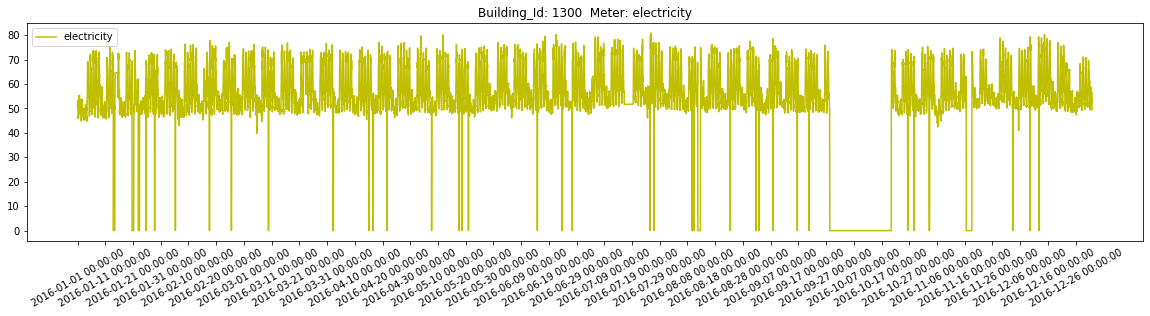

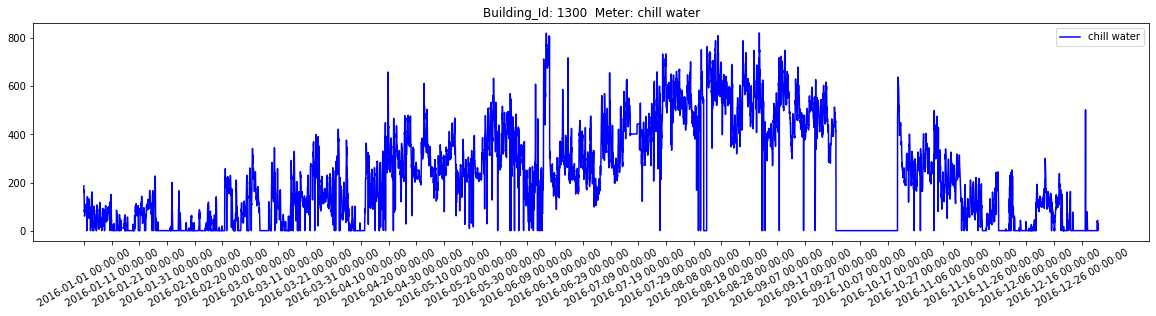

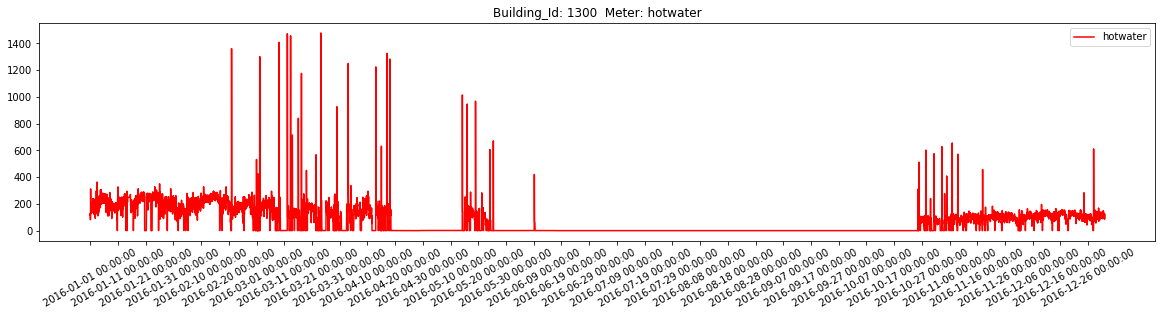

In [63]:
plot_meter(1300)

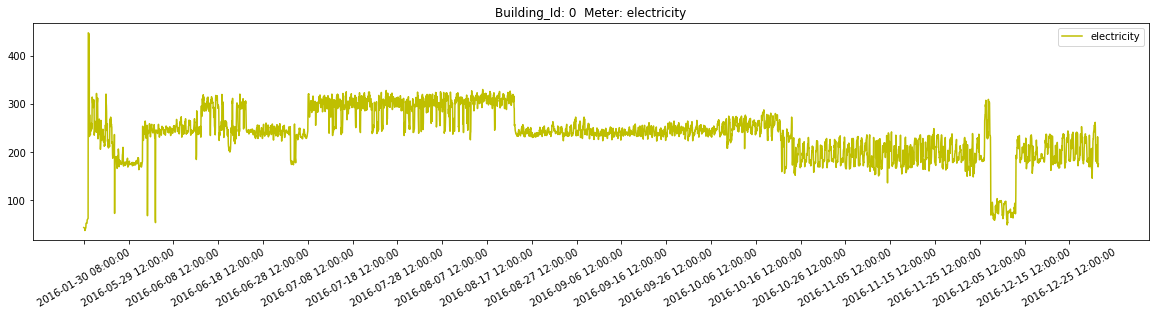

In [95]:
plot_meter(0)

In [96]:
temp = train[train['building_id'] == 0]
temp.head(200)

,building_id,meter,meter_reading,timestamp
1617286,0,0,43.683900,2016-01-30 08:00:00
1619591,0,0,43.391371,2016-01-30 09:00:00
1621897,0,0,43.098843,2016-01-30 10:00:00
1624206,0,0,42.806314,2016-01-30 11:00:00
1626515,0,0,42.513786,2016-01-30 12:00:00
1628823,0,0,42.221257,2016-01-30 13:00:00
1665732,0,0,37.540800,2016-01-31 05:00:00
1668037,0,0,38.792158,2016-01-31 06:00:00
1670101,0,0,40.043517,2016-01-31 07:00:00
1672167,0,0,41.294875,2016-01-31 08:00:00


In [80]:
temp['shifted_past'] = temp['meter_reading'].shift()
temp['shifted_future'] = temp['meter_reading'].shift(-1)
temp['shifted_past_diff'] = np.abs(temp['meter_reading'] - temp['shifted_past'])
temp['shifted_future_diff'] = np.abs(temp['meter_reading'] - temp['shifted_future'])
temp[3000:4000]

,building_id,meter,timestamp,meter_reading,shifted_past,shifted_future,shifted_past_diff,shifted_future_diff
6725315,1300,3,2016-05-05 14:00:00,1.1451,1.0579,1.1097,0.0872,0.0354
6727661,1300,3,2016-05-05 15:00:00,1.1097,1.1451,1.0930,0.0354,0.0167
6730009,1300,3,2016-05-05 16:00:00,1.0930,1.1097,1.0765,0.0167,0.0165
6732355,1300,3,2016-05-05 17:00:00,1.0765,1.0930,1.0895,0.0165,0.0130
6734701,1300,3,2016-05-05 18:00:00,1.0895,1.0765,1.0344,0.0130,0.0551
6737047,1300,3,2016-05-05 19:00:00,1.0344,1.0895,0.9848,0.0551,0.0496
6739394,1300,3,2016-05-05 20:00:00,0.9848,1.0344,1.0636,0.0496,0.0788
6741739,1300,3,2016-05-05 21:00:00,1.0636,0.9848,1.1481,0.0788,0.0845
6744085,1300,3,2016-05-05 22:00:00,1.1481,1.0636,1.1219,0.0845,0.0262
6746431,1300,3,2016-05-05 23:00:00,1.1219,1.1481,1.0843,0.0262,0.0376


In [83]:
std_past = temp['shifted_past_diff'].std()
std_future = temp['shifted_future_diff'].std()
std_ = temp['meter_reading'].std()
median = temp['meter_reading'].median()
mean = temp['meter_reading'].mean()

print(std_past)
print(std_future)
print(std_)
print(median)
print(mean)

80.78086509551608
80.78086509551608
99.43781325204294
0.7144
66.28813933584388


In [84]:
id_ = []
meters = []

maxs_ = []
medians_ = []
means_ = []

for id in tqdm(range(train['building_id'].nunique())):
    for i in range(4):
        temp = train[train['building_id'] == id]
        temp = temp[temp['meter'] == i]
        
        if temp.empty:
            continue
            
        means_.append(temp['meter_reading'].mean())
        medians_.append(temp['meter_reading'].median())
        maxs_.append(temp['meter_reading'].max())
        id_.append(id)
        meters.append(i)
        
exam_df = pd.DataFrame({
    'building_id': id_,
    'meter': meters,
    'mean': means_,
    'median': medians_,
    'max': maxs_
})

exam_df['diff_max_median'] = exam_df['max'] - exam_df['median']

In [85]:
exam_df

,building_id,meter,mean,median,max,diff_max_median
0,0,0,1.464550e+02,189.75200,4.480000e+02,2.582480e+02
1,1,0,7.486539e+01,95.01240,2.550000e+02,1.599876e+02
2,2,0,1.455138e+01,9.41930,6.798300e+01,5.856370e+01
3,3,0,2.355500e+02,315.68400,9.370000e+02,6.213160e+02
4,4,0,9.765567e+02,1450.44000,3.592000e+03,2.141560e+03
5,5,0,1.789445e+01,13.99250,7.508160e+01,6.108910e+01
6,6,0,6.406661e+01,76.99280,2.661990e+02,1.892062e+02
7,7,0,3.503342e+02,491.78500,1.160000e+03,6.682150e+02
8,7,1,3.097044e+03,3039.15000,8.442070e+03,5.402920e+03
9,8,0,2.569278e+02,365.51100,7.490000e+02,3.834890e+02
